# Generative models; Diffusion Models

**Diffusion Models** ([Sohl-Dickstein et al., 2015](https://arxiv.org/pdf/1503.03585), [Ho et al., 2020](https://arxiv.org/pdf/2006.11239), [Rombach et al., 2022](https://arxiv.org/pdf/2112.10752)) are last, but certainly not least category of generative models we will learn about. They are inspired by the diffusion process, namely is the movement of particles move from an area of high concentration to an area of low concentration until equilibrium is reached at temperatures above absolute zero $\tau > 0$ K. The result of diffusion is a gradual mixing of substances, that will eventually result in complete mixing:

[![](https://upload.wikimedia.org/wikipedia/commons/9/90/Diffusion_microscopic_picture.gif)]()

*source: Wikipedia*

Diffusion models mimic the thermal diffusion process by gradually adding noise $T \to \infty$ times to the 
dat until it is degraded to random noise drawn from probability distributiona $\pi(x)h:

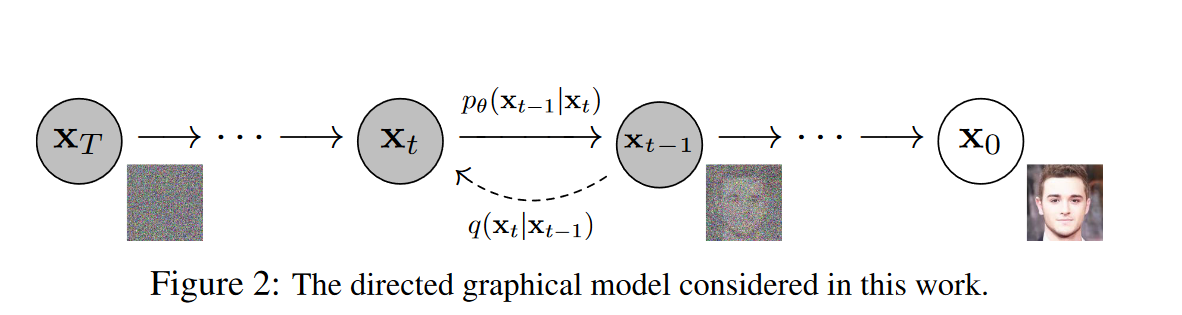
*source: [Ho et al., 2020](https://arxiv.org/pdf/2006.11239)

The model is able to generate new observations by traversing this process in the reverse order: from noise to data. A training goal is to find proper masks representing each step of the reverse diffusion process. .

By definition, the diffusion process is modelled as a **Markov chain on a measurable state space**, where the transition probability is represented by the **diffusion coefficient** $D_\pi(x|x^\prime, \beta)$, where $\beta$ is the **rate of diffusion** (*variance*):
$$\pi(x) = \int D_\pi(x|x^\prime, \beta) \pi(x^\prime) dx^\prime $$
in particular:
$$q(x_t|x_{t-1}) = D_\pi(x_t|x_{t-1}, \beta_t)$$

We assume that $\pi(x)$ is analytically solvable, e.g. it is an isotropic Gaussian distribution, thus the noise added in the single diffusion step can also be represented as a random variable drawn from the Gaussian distribution:

$$q(x_t|x_{t-1}) = \mathcal{N}(x_{t-1},\sqrt{1 - \beta_t}x_{t-1}, \beta_t \bf{I})$$

Moreover,  we assume that the sequence $\{\beta_t \in (0,1)\}_i^T$ (a *variance schedule*) is strictly increasing - the further we move from the original data $x_0$, the more noise we add to it.

At the time step $T$, we get:
$$q(x_{0:T}) = q(x_0)\prod_{t=1}^Tq(x_t|x_{t-1})$$

Reverse diffusion behaves almost exactly the same:

$$p(x_0) = \int p(x_{0:T})dx_{0:T}$$

or:

$$p(x_{0:T}) = p(x_T)\prod_{t=1}^T p(x_{t-1}|x_t)$$,

where $x_T \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. 

Our goal is to train a model that represents the reverse diffusion process for every $x_0$. Mathematically speaking, our goal is to approximate $p(x)$ with $p_\theta(x_0)$ such that:
$$p_\theta(x_0) = p_\theta(x_T)\prod_{t=1}^T p_\theta(x_{t-1}|x_t) \; \mathrm{where} \;  p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \Sigma_\theta(x_t,t))$$


As a result, we want to minimize the entropy between the diffusion $q(x_0)$ and the approximated diffusion $p_\theta(x_0)$:

$$
\begin{aligned}
L
&= - \mathbb{E}_{q(x_0)} \log p_\theta(x_0) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \int p(x_{0:T})dx_{0:T} \Big) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \int q(x_{0:T} \vert x_0) \frac{p_\theta(x_{0:T})}{q(x_{0:T} \vert x_0)} dx_{0:T} \Big) \\
&= - \mathbb{E}_{q(x_0)} \log \Big( \mathbb{E}_{q(x_{0:T})} \frac{p_\theta(x_{0:T})}{q(x_{0:T})} \Big)
\end{aligned}
$$

By Jensen inequality:

$$
\begin{aligned}
L
&\leq - \mathbb{E}_{q(x_{0:T})} \log \frac{p_\theta(x_{0:T})}{q(x_{0:T} \vert \mathbf{x}_{0})} \\
&= \mathbb{E}_{q(x_{0:T})}\Big[\log \frac{q(x_{0:T} \vert \mathbf{x}_{0})}{p_\theta(x_{0:T})} \Big] \\
&= \mathbb{E}_q \Big[ \log\frac{\prod_{t=1}^T q(x_t\vert x_{t-1})}{ p_\theta(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \vert x_t) } \Big] = L_\text{ELBO}
\end{aligned}
$$

Finally, our goal is to maximize $L_\text{ELBO}$:
$$p_{\theta^*}(x_{t_1} \vert x_t) = \underset{p_{\theta}(x_{t_1} \vert x_t)}{\text{argmax}} \: L_\text{ELBO}$$

However, we must rewrite  $L_\text{ELBO}$  to make it computationally trackable. After some transformations, we get: 


$$
\begin{aligned}
L_\text{ELBO} &= \mathbb{E}_q \Big[ \log\frac{\prod_{t=1}^T q(x_t\vert x_{t-1})}{ p_\theta(x_T) \prod_{t=1}^T p_\theta(x_{t-1} \vert x_t) } \Big] \\
&= \mathbb{E}_q [\underbrace{D_\text{KL}(q(x_T \vert x_0) \parallel p_\theta(x_T))}_{L_T} + \sum_{t=2}^T \underbrace{D_\text{KL}(q(x_{t-1} \vert x_t, x_0) \parallel p_\theta(x_{t-1} \vert x_t))}_{L_{t-1}} - \underbrace{\log p_\theta(x_0 \vert x_1)}_{L_0} ] 
\end{aligned}
$$

$\beta_t$ is constant, thus $(q(x_T \vert x_0)$ has no learnable parameters and  $p_\theta(x_T)$ is just a random noise drawn from  $\mathcal{N}(\mathbf{0}, \mathbf{I})$, as a result, $L_T$ is constant and negligible. For every $t \geq 2$ $L_{t-1}$ is a KL divergence between two Gaussian distributions, thus it is easy to find its closed form. $L_0$ is the only non-parametric element of the loss function.

Let us proceed with an experiment:

In [1]:
using Flux, MLDatasets
using Flux: mse, @functor, Statistics, onehotbatch, params
using Base.Iterators: partition
using Printf, BSON, JLD2, LinearAlgebra
using Zygote
using Images, Plots
using CUDA
using Random
using Statistics

In [2]:
use_cuda = true

true

In [3]:
 if use_cuda && CUDA.functional()
    device = gpu
    @info "Training on GPU"
else
    device = cpu
    @info "Training on CPU"
end

[ Info: Training on GPU


Model's parameters:

In [4]:
batch_size = 64
T = 1000
β₀ = 1e-4
βT =0.02
βs = range(β₀, βT, length = T)
α = Float32.(1. .- βs)
α⁻ = cumprod(α);

data:

In [5]:
train_set = MNIST(:train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [6]:
Y = onehotbatch(train_set.targets, 0:9)   |> device;

In [7]:
imgs = reshape(@.(2f0 * train_set.features - 1f0), 28, 28, 1, :);

In [8]:
dataset = [(imgs[:,:,:,i], Y[:,i]) for i in partition(1:size(imgs,4), batch_size)] |> device;

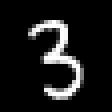

In [9]:
Gray.(transpose((dropdims((cpu(dataset[3][1][:,:,:,9]).+1.f0) ./ 2.f0; dims = 3))))

Auxiliary function, that allows us to expand the dimensionality of a vector: 

In [10]:
expand_dims(x::AbstractVecOrMat, dims::Int=2) = reshape(x, (ntuple(i -> 1, dims)..., size(x)...))

expand_dims (generic function with 2 methods)

Before the training begins, we must define the **positional encoding** of every time step. The architecture itself will be static, with no built-in mechanism for controlling the order of data. Hence, we must explicitly add the positional information to the model.

We cannot do this by merely adding the time index $t$ - the model will not be able to comprehend such information. As a result, we must embed the time data in a proper latent space. We will do this by using the **positional encoding**  scheme introduced together with **attention models** [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762). For every $t = {1,2,\dots,T}$ we define embedding $\mathcal{E}(t)$ as: 

$$
\begin{eqnarray}
\mathcal{E}(t, 2i) &=& \sin\Big(\frac{t}{n^{2i/d}}\Big)\\
\mathcal{E}(t, 2i+1) &=& \cos\Big(\frac{t}{n^{2i/d}}\Big)
\end{eqnarray}
$$

where $\mathcal{E}(t, j)$ is a single term of a matrix $\mathcal{E}(t)$ with indices $t$ and $j$ , $d$ is a dimension of the output embedding, $i = 0,2,\dots,d/2$ is a row position, and $n$ is a fixed scalar (usually 10 000).

In [11]:
function PositionalEncoding(embed_dim)
    # Instantiate ω once
    ω =  1 ./ (10000.f0 .^ (collect(0:2:embed_dim-1) ./ embed_dim))
    # Return a function that always references the same ω
    PositionalEncoding(t) = Float32.(vcat(sin.(ω * t'), cos.(ω * t')))
end

PositionalEncoding (generic function with 1 method)

alternatively [(Tancik et al. 2020)](https://arxiv.org/abs/2006.10739):

In [12]:
function GaussianFourierProjection(embed_dim, scale)
    # Instantiate W once
    W = randn(Float32, embed_dim ÷ 2) .* scale
    # Return a function that always references the same W
    function GaussFourierProject(t)
        t_proj = t' .* W * Float32(2π)
        [sin.(t_proj); cos.(t_proj)]
    end
end

GaussianFourierProjection (generic function with 1 method)

We will use **U-Net** [(Ronneberger et al., 2015)](https://arxiv.org/abs/1505.04597) as a neural network architecture:
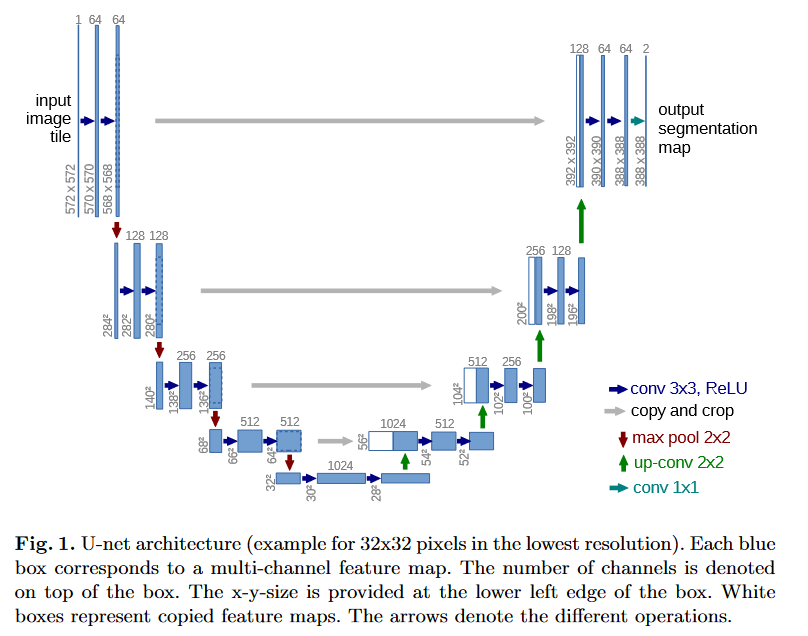
*źródło: [Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597)*

U-Net is a convolutional neural network that was developed for image segmentation, a computer vision technique that partitions a digital image into discrete groups of pixels, so-called image segments. It is often used to detect objects, parts of a picture that share certain characteristics, etc. 

In [13]:
struct UNet
    #label embedding
    label_embed::Flux.Chain
    #time embedding
    time_embed::Flux.Chain
    #UNet Layers
    embed_layers::NamedTuple
    conv_layers::NamedTuple
    gnorm_layers::NamedTuple
end

In [14]:
function UNet(time_dim=256, label_dim = 1, scale=30.0f0)
    label_embed = Chain(Dense(10,28^2 * label_dim), x-> reshape(x, 28, 28, label_dim, size(x, 2)))
    time_embed = Chain(PositionalEncoding(time_dim), Dense(time_dim, time_dim, swish))
    embed_layers = (encode1 = Dense(time_dim, 32),
                    encode2 = Dense(time_dim, 64),
                    encode3 = Dense(time_dim, 128),
                    encode4 = Dense(time_dim, 256),
                    decode1 = Dense(time_dim, 128),
                    decode2 = Dense(time_dim, 64),
                    decode3 = Dense(time_dim, 32))
    conv_layers = (encode1 = Conv((3, 3), 1 + label_dim => 32, stride=1, bias=false),
                   encode2 = Conv((3, 3), 32 => 64, stride=2, bias=false),
                   encode3 = Conv((3, 3), 64 => 128, stride=2, bias=false),
                   encode4 = Conv((3, 3), 128 => 256, stride=2, bias=false),
                   decode1 = ConvTranspose((3, 3), 256 => 128, stride=2, bias=false),
                   decode2 = ConvTranspose((4, 4), 128 + 128 => 64, stride=2, bias=false),
                   decode3 = ConvTranspose((4, 4), 64 + 64 => 32, stride=2, bias=false),
                   decode4 =ConvTranspose((3, 3), 32 + 32 => 1, stride=1, bias=false))
    gnorm_layers = (encode1 = GroupNorm(32, 4, swish),
                    encode2 = GroupNorm(64, 32, swish),
                    encode3 =GroupNorm(128, 32, swish),
                    encode4 =GroupNorm(256, 32, swish),
                    decode1 = GroupNorm(128, 32, swish),
                    decode2 = GroupNorm(64, 32, swish),
                    decode3 = GroupNorm(32, 32, swish))
    return UNet(label_embed,time_embed, embed_layers, conv_layers, gnorm_layers)
end

@functor UNet

In [15]:
function (unet::UNet)(x, label, t)
    #Label embedding
    label = unet.label_embed(label)
    #Time embedding
    embed = unet.time_embed(t)
    #UNet encoder
    h0 = cat(x, label, dims = 3)
    
    h1 = unet.conv_layers.encode1(h0)
    h1 = unet.gnorm_layers.encode1(h1)
    h1 = h1 .+ expand_dims(unet.embed_layers.encode1(embed), 2)
    
    h2 = unet.conv_layers.encode2(h1)
    h2 = unet.gnorm_layers.encode2(h2)
    h2 = h2 .+ expand_dims(unet.embed_layers.encode2(embed), 2)
    
    h3 = unet.conv_layers.encode3(h2)
    h3 = unet.gnorm_layers.encode3(h3)
    h3 = h3 .+ expand_dims(unet.embed_layers.encode3(embed), 2)
    
    h4 = unet.conv_layers.encode4(h3)
    h4 = unet.gnorm_layers.encode4(h4)
    h4 = h4 .+ expand_dims(unet.embed_layers.encode4(embed), 2)
    
    #Decoder
    h = unet.conv_layers.decode1(h4)
    h = unet.gnorm_layers.decode1(h)
    h = h .+ expand_dims(unet.embed_layers.decode1(embed), 2)
    
    h = cat(h, h3; dims=3)
    h = unet.conv_layers.decode2(h)
    h = unet.gnorm_layers.decode2(h)
    h = h .+ expand_dims(unet.embed_layers.decode2(embed), 2)
    
    h = cat(h, h2; dims=3)
    h = unet.conv_layers.decode3(h)
    h = unet.gnorm_layers.decode3(h)
    h = h .+ expand_dims(unet.embed_layers.decode3(embed), 2)
    
    h = cat(h, h1; dims=3)
    h = unet.conv_layers.decode4(h)
end

In [16]:
model = UNet() |> device;

We model the diffusion process as a Markov chain with Gaussian distributed variables. As a result, we could easily compute the value of $x_t$ in every step. Assume that  $\alpha = 1 -\beta$ and $\bar{\alpha}  = \prod_{i=1}^t \alpha_i$, then:

$$
\begin{aligned}
x_t &= \sqrt{\alpha_t}x_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1}  \\
&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t (1 - \alpha_{t-1})} \boldsymbol{\epsilon}_{t-2}  + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1}  \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} \\
\end{aligned}
$$
where $\boldsymbol{\epsilon}, \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$.

Finally, we get a transition probability from $x_0$ to $x_t$:

$$q(x_t \vert x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t)\mathbf{I})$$

Written as a code:

In [17]:
function noise_images(x,t)
    α_hat = reshape(α⁻[t],1,1,size(x)[3:4]...) |> device
    ϵ = Flux.randn_like(x)
    sqrt.(α_hat) .* x + sqrt.(1 .- α_hat) .* ϵ, ϵ
end

noise_images (generic function with 1 method)

$q(x_t \vert x_{t-1})$ is a Gaussian process, thus its inverse: $q(x_{t-1} \vert x_t)$ also has this property. Moreover, we could easily find its explicit form, assuming that it is conditioned on  $x_0$: 

$q(x_{t-1} \vert x_t, x_0) = \mathcal{N}(x_{t-1},\tilde{\mu}(x_t,x_0), \tilde{\beta_t} \bf{I})$

It turns out that parameters $\tilde{\mu}$ and $\tilde{\beta_t}$ of such distribution are equal to:
$$
\begin{aligned}
\tilde{\beta}_t 
&= \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t \\
\tilde{\mu}_t (x_t, x_0)
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} x_0\\
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t - \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t) \\
&= \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)
\end{aligned}
$$



Now, we must find a good parametrization of the reverse diffusion process $p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t,t), \Sigma_\theta(x_t,t))$, namely we are interested in finding the $\mu_\theta$ that will approximate $\tilde{\mu_t}$ for every $t$. After some calculations, the loss function term $L_{t-1}$ reduces to mean squared error between  $\tilde{\mu_t}$ and  $\mu_\theta$:

$$
\begin{aligned}
L_{t-1} 
&\approx \mathbb{E}_{q} \Big[\frac{1}{2 \| \Sigma_\theta(x_t, t) \|^2_2} \| \tilde{\mu}_t(x_t, x_0) - \mu_\theta(x_t, t) \|^2 \Big] \\
&= \mathbb{E}_{x_0, \boldsymbol{\epsilon}} \Big[\frac{1}{2 \| \Sigma_\theta \|^2_2} \| \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big) - \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta(x_t, t) \Big) \|^2 \Big] \\
&= \mathbb{E}_{x_0, \boldsymbol{\epsilon}} \Big[\frac{ \beta_t^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \Sigma_\theta \|^2_2} \|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(x_t, t)\|^2 \Big] \\
\end{aligned}
$$

Moreover, we can simplify the loss function (and improve the quality of the model!) by omitting the  $\frac{ \beta_t^2 }{2 \alpha_t (1 - \bar{\alpha}_t) \| \Sigma_\theta \|^2_2}$ coefficient. After this step, the loss function takes the form:
$$
\begin{aligned}
L_{t-1}^\text{simple}
&= \mathbb{E}_{t, x_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(x_t, t)\|^2 \Big] \\
&= \mathbb{E}_{t, x_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)\|^2 \Big]
\end{aligned}
$$

Lastly, calculating the expected value of $L_{t-1}$ is not necessary; we can use the **reparametrization trick** and just calculate the value for a random batch of data - when training is long enough, the result will be roughly the same. 

Definitions of sampling functions:

In [22]:
function sample(x, labels)
    @eval NNlib.within_gradient(generator) = false
    for t in T:-1:1
        predicted_noise = model(x, labels, t)
        alpha = α[t] |> device
        alpha_hat = α⁻[t] |> device
        beta = βs[t] |> device
        if t > 1
            noise = Flux.randn_like(x)
        else
            noise = Flux.zeros_like(x)
        end
        x = 1 ./ sqrt.(alpha) * (x - ((1 .- alpha) ./ (sqrt.(1 .- alpha_hat))) .* predicted_noise) .+ sqrt.(beta) .* noise
    end
    @eval NNlib.within_gradient(generator) = true
    x = (clamp.(x, -1.f0, 1.f0) .+ 1.f0) ./ 2.f0 |> cpu
    hcat([Gray.(transpose(reshape(x[:,:,:,i], 28, 28))) for i = 1:size(x)[4]]...)
end

sample (generic function with 1 method)

In [23]:
function sample_animate(x, labels, gif_name; forward = false, FPS = 10, gif_length = 5)
    frame_freq = T/(FPS*gif_length)
    frames = []
    @eval NNlib.within_gradient(generator) = false
    if forward
        for t in 1:1:T
            α_hat = α⁻[t]
            ϵ = Flux.randn_like(x)
            x = sqrt.(α_hat) .* x + sqrt.(1 .- α_hat) .* ϵ
            if mod(t,frame_freq) == 0
                xp = (clamp.(x, -1.f0, 1.f0) .+ 1.f0) ./ 2.f0 |> cpu
                p = plot(hcat([Gray.(transpose(reshape(xp[:,:,:,i], 28, 28))) for i = 1:size(x)[4]]...),
                    ticks = false, showaxis = false)
                push!(frames,p)
            end
        end 
    else
        for t in T:-1:1
            predicted_noise = model(x, labels, t)
            alpha = α[t] |> device
            alpha_hat = α⁻[t] |> device
            beta = βs[t] |> device
            if t > 1
                noise = Flux.randn_like(x)
            else
                noise = Flux.zeros_like(x)
            end
            x = 1 ./ sqrt.(alpha) * (x - ((1 .- alpha) ./ (sqrt.(1 .- alpha_hat))) .* predicted_noise) .+ sqrt.(beta) .* noise
            if mod(t,frame_freq) == 0
                xp = (clamp.(x, -1.f0, 1.f0) .+ 1.f0) ./ 2.f0 |> cpu
                p = plot(hcat([Gray.(transpose(reshape(xp[:,:,:,i], 28, 28))) for i = 1:size(x)[4]]...),
                    ticks = false, showaxis = false)
                push!(frames,p)
            end 
        end
    end
    @eval NNlib.within_gradient(generator) = true
    anim = @animate for frame in frames
        plot(frame)
    end
    anim
    gif(anim, gif_name, fps = FPS)
end

sample_animate (generic function with 1 method)

[ Info: Saved animation to C:\Users\barto\forward.gif


Plots.AnimatedGif("C:\\Users\\barto\\forward.gif")
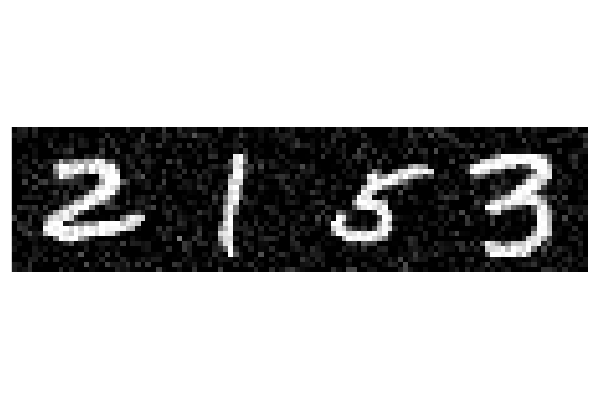

In [24]:
btch = rand(1:batch_size,4)
sample_animate(dataset[3][1][:,:,:,btch],
                    dataset[3][2][:, btch], "forward.gif", forward=true)

Optimizer:

In [25]:
opt = Flux.Adam(0.001)  
opt_state = Flux.setup(opt, model);

Now, it is time for the training:

In [26]:
x0 = Flux.randn_like(dataset[3][1][:,:,:,rand(1:batch_size,4)]);
label = dataset[3][2][:, rand(1:batch_size,4)];

1×4 Matrix{Int64}:
 8  4  5  0

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Conv((3, 3), 2 => 32, bias=false)  # 576 parameters
│   summary(x) = "28×28×2×4 CuArray{Float64, 4, CUDA.DeviceMemory}"
└ @ Flux C:\Users\barto\.julia\packages\Flux\htpCe\src\layers\stateless.jl:59


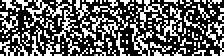

[ Info: Beginning training loop...
[ Info: Epoch 1
┌ Warning: Performing scalar indexing on task Task (runnable, started) @0x000001ab63458da0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore C:\Users\barto\.julia\packages\GPUArraysCore\GMsgk\src\GPUArraysCore.jl:149
[ Info: Epoch: 1, loss = 0.11403625173720597


1×4 Matrix{Int64}:
 8  4  5  0

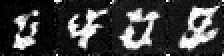

[ Info: Epoch 2
[ Info: Epoch: 2, loss = 0.050331726854941104


1×4 Matrix{Int64}:
 8  4  5  0

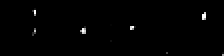

[ Info: Epoch 3
[ Info: Epoch: 3, loss = 0.04332831199529138


1×4 Matrix{Int64}:
 8  4  5  0

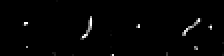

[ Info: Epoch 4
[ Info: Epoch: 4, loss = 0.04022932911851704


1×4 Matrix{Int64}:
 8  4  5  0

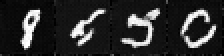

[ Info: Epoch 5
[ Info: Epoch: 5, loss = 0.037850223352580564


1×4 Matrix{Int64}:
 8  4  5  0

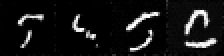

[ Info: Epoch 6
[ Info: Epoch: 6, loss = 0.03604216020363671


1×4 Matrix{Int64}:
 8  4  5  0

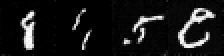

[ Info: Epoch 7
[ Info: Epoch: 7, loss = 0.034966298003694905


1×4 Matrix{Int64}:
 8  4  5  0

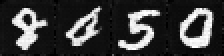

[ Info: Epoch 8
[ Info: Epoch: 8, loss = 0.03407601331239506


1×4 Matrix{Int64}:
 8  4  5  0

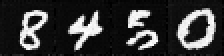

[ Info: Epoch 9
[ Info: Epoch: 9, loss = 0.033327542545238155


1×4 Matrix{Int64}:
 8  4  5  0

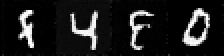

[ Info: Epoch 10
[ Info: Epoch: 10, loss = 0.03227296035522337


1×4 Matrix{Int64}:
 8  4  5  0

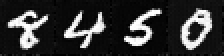

[ Info: Epoch 11
[ Info: Epoch: 11, loss = 0.03188598200158556


1×4 Matrix{Int64}:
 8  4  5  0

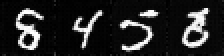

[ Info: Epoch 12
[ Info: Epoch: 12, loss = 0.0312840460694389


1×4 Matrix{Int64}:
 8  4  5  0

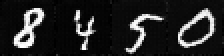

[ Info: Epoch 13
[ Info: Epoch: 13, loss = 0.031186332431699295


1×4 Matrix{Int64}:
 8  4  5  0

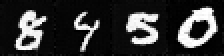

[ Info: Epoch 14
[ Info: Epoch: 14, loss = 0.030280482272174693


1×4 Matrix{Int64}:
 8  4  5  0

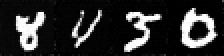

[ Info: Epoch 15
[ Info: Epoch: 15, loss = 0.029989777645195472


1×4 Matrix{Int64}:
 8  4  5  0

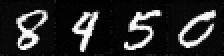

[ Info: Epoch 16
[ Info: Epoch: 16, loss = 0.029799606019595283


1×4 Matrix{Int64}:
 8  4  5  0

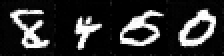

[ Info: Epoch 17
[ Info: Epoch: 17, loss = 0.029443693007709885


1×4 Matrix{Int64}:
 8  4  5  0

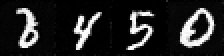

[ Info: Epoch 18
[ Info: Epoch: 18, loss = 0.029082490895777496


1×4 Matrix{Int64}:
 8  4  5  0

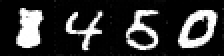

[ Info: Epoch 19
[ Info: Epoch: 19, loss = 0.028969915495363315


1×4 Matrix{Int64}:
 8  4  5  0

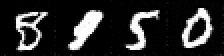

[ Info: Epoch 20
[ Info: Epoch: 20, loss = 0.028453156985501365


1×4 Matrix{Int64}:
 8  4  5  0

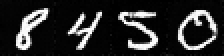

[ Info: Epoch 21
[ Info: Epoch: 21, loss = 0.02858428568291321


1×4 Matrix{Int64}:
 8  4  5  0

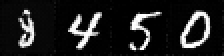

[ Info: Epoch 22
[ Info: Epoch: 22, loss = 0.02829328884305095


1×4 Matrix{Int64}:
 8  4  5  0

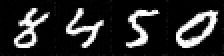

[ Info: Epoch 23
[ Info: Epoch: 23, loss = 0.02815484957717883


1×4 Matrix{Int64}:
 8  4  5  0

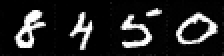

[ Info: Epoch 24
[ Info: Epoch: 24, loss = 0.0279442524162135


1×4 Matrix{Int64}:
 8  4  5  0

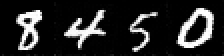

[ Info: Epoch 25
[ Info: Epoch: 25, loss = 0.027764160508738714


1×4 Matrix{Int64}:
 8  4  5  0

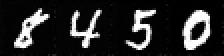

[ Info: Epoch 26
[ Info: Epoch: 26, loss = 0.02752581453705425


1×4 Matrix{Int64}:
 8  4  5  0

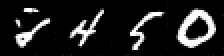

[ Info: Epoch 27
[ Info: Epoch: 27, loss = 0.027674692344349393


1×4 Matrix{Int64}:
 8  4  5  0

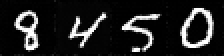

[ Info: Epoch 28
[ Info: Epoch: 28, loss = 0.02749208240771789


1×4 Matrix{Int64}:
 8  4  5  0

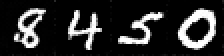

[ Info: Epoch 29
[ Info: Epoch: 29, loss = 0.027252979565665983


1×4 Matrix{Int64}:
 8  4  5  0

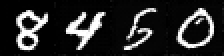

[ Info: Epoch 30
[ Info: Epoch: 30, loss = 0.027123989818343665


1×4 Matrix{Int64}:
 8  4  5  0

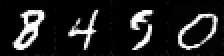

[ Info: Epoch 31
[ Info: Epoch: 31, loss = 0.02743413303194365


1×4 Matrix{Int64}:
 8  4  5  0

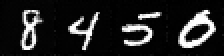

[ Info: Epoch 32
[ Info: Epoch: 32, loss = 0.027033485294476564


1×4 Matrix{Int64}:
 8  4  5  0

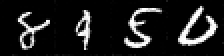

[ Info: Epoch 33
[ Info: Epoch: 33, loss = 0.027189947035251013


1×4 Matrix{Int64}:
 8  4  5  0

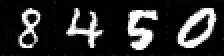

[ Info: Epoch 34
[ Info: Epoch: 34, loss = 0.026901112215073186


1×4 Matrix{Int64}:
 8  4  5  0

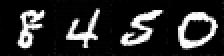

[ Info: Epoch 35
[ Info: Epoch: 35, loss = 0.02695615423211792


1×4 Matrix{Int64}:
 8  4  5  0

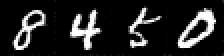

[ Info: Epoch 36
[ Info: Epoch: 36, loss = 0.02640737003303254


1×4 Matrix{Int64}:
 8  4  5  0

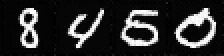

[ Info: Epoch 37
[ Info: Epoch: 37, loss = 0.02661196826331651


1×4 Matrix{Int64}:
 8  4  5  0

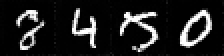

[ Info: Epoch 38
[ Info: Epoch: 38, loss = 0.026459462532618723


1×4 Matrix{Int64}:
 8  4  5  0

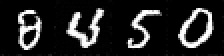

[ Info: Epoch 39
[ Info: Epoch: 39, loss = 0.026551339936170624


1×4 Matrix{Int64}:
 8  4  5  0

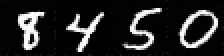

[ Info: Epoch 40
[ Info: Epoch: 40, loss = 0.02646481177445922


1×4 Matrix{Int64}:
 8  4  5  0

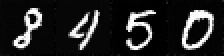

[ Info: Epoch 41
[ Info: Epoch: 41, loss = 0.02594217219785142


1×4 Matrix{Int64}:
 8  4  5  0

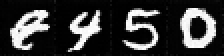

[ Info: Epoch 42
[ Info: Epoch: 42, loss = 0.026020324368006005


1×4 Matrix{Int64}:
 8  4  5  0

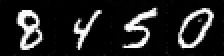

[ Info: Epoch 43
[ Info: Epoch: 43, loss = 0.026316334612604016


1×4 Matrix{Int64}:
 8  4  5  0

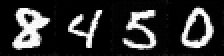

[ Info: Epoch 44
[ Info: Epoch: 44, loss = 0.026446611482475294


1×4 Matrix{Int64}:
 8  4  5  0

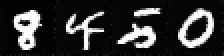

[ Info: Epoch 45
[ Info: Epoch: 45, loss = 0.026459316814393757


1×4 Matrix{Int64}:
 8  4  5  0

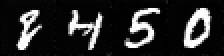

[ Info: Epoch 46
[ Info: Epoch: 46, loss = 0.026306466292788478


1×4 Matrix{Int64}:
 8  4  5  0

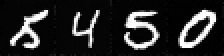

[ Info: Epoch 47
[ Info: Epoch: 47, loss = 0.025977160544323325


1×4 Matrix{Int64}:
 8  4  5  0

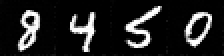

[ Info: Epoch 48
[ Info: Epoch: 48, loss = 0.025978268895631852


1×4 Matrix{Int64}:
 8  4  5  0

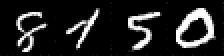

[ Info: Epoch 49
[ Info: Epoch: 49, loss = 0.025775218959341744


1×4 Matrix{Int64}:
 8  4  5  0

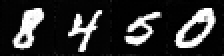

[ Info: Epoch 50
[ Info: Epoch: 50, loss = 0.025948750906621913


1×4 Matrix{Int64}:
 8  4  5  0

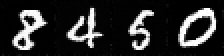

[ Info: Done! Saving model out to diffusionMNIST.bson


In [27]:
display(reduce(vcat, reduce.(hcat, partition(Flux.onecold(cpu(label)), 4))) .- 1)
display(sample(x0,label))
@info("Beginning training loop...")
for epoch = 1:50
    mloss = 0.0
    @info "Epoch $epoch"
    for (x, labels) in dataset
        ps = params(model)
        bloss, back = Zygote.pullback(ps) do
            t = rand(1:T, size(x)[end]) |> device
            xₜ, noise = noise_images(x, t)
            predicted_noise = model(xₜ, labels, t)
            Flux.mse(noise, predicted_noise)
        end
        grads = back(1f0)
        Flux.Optimise.update!(opt, ps, grads)
        mloss += bloss 
    end
    mloss /= length(dataset)
    @info("Epoch: $epoch, loss = $mloss")
    display(reduce(vcat, reduce.(hcat, partition(Flux.onecold(cpu(label)), 4))) .- 1)
    display(sample(x0,label))
end
@info("Done! Saving model out to diffusionMNIST.bson")
jldsave("diffusionMNIST.jld2"; UNet = cpu(Flux.state(model)))

Let us test a trained model:

In [28]:
model = UNet() |> device;
ps = JLD2.load("diffusionMNIST.jld2", "UNet")
Flux.loadmodel!(model, device(ps));

1×4 Matrix{Int64}:
 7  4  5  2

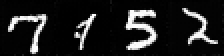

In [29]:
x0 = Flux.randn_like(dataset[3][1][:,:,:,rand(1:batch_size,4)]);
label = dataset[3][2][:, rand(1:batch_size,4)];
display(reduce(vcat, reduce.(hcat, partition(Flux.onecold(cpu(label)), 4))) .- 1)
display(sample(x0,label))

[ Info: Saved animation to C:\Users\barto\after.gif


Plots.AnimatedGif("C:\\Users\\barto\\after.gif")
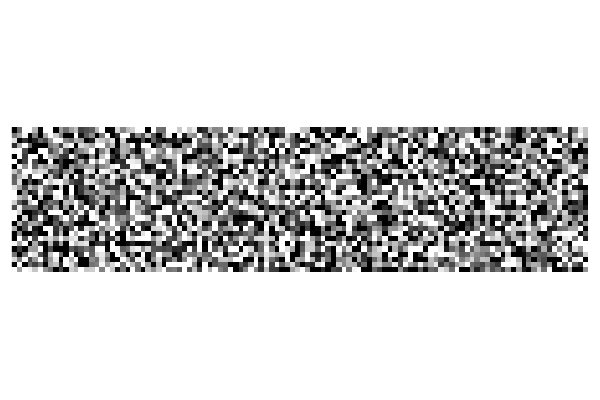

In [30]:
sample_animate(x0,label, "after.gif")